In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashmotiani/dogs-skin-disease-dataset")

print("Path to dataset files:", path)

100%|██████████| 188M/188M [00:02<00:00, 78.4MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/yashmotiani/dogs-skin-disease-dataset/versions/1


In [2]:
!kaggle datasets download yashmotiani/dogs-skin-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/yashmotiani/dogs-skin-disease-dataset
License(s): CC0-1.0
 96% 180M/188M [00:00<00:00, 231MB/s]
100% 188M/188M [00:00<00:00, 207MB/s]


In [3]:
!unzip dogs-skin-disease-dataset.zip -d /content/dataset

Archive:  dogs-skin-disease-dataset.zip
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/453.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/454.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/5.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/56.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/56f.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/572 (2).jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/572.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/75.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/752.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/78.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/877.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/89.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/Bacteria3_png.rf.399d3cc1019e2c019ec4d7cf6f6f3a2e.jpg  
  inflating: /content/dataset/Dogs/Bacterial_dermatosis/Ba

In [4]:
import matplotlib.pyplot as plt # Importing the pyplot module from matplotlib and aliasing it as plt
import os
import cv2
import numpy as np

In [5]:
#function to load the images and their corresponding labels
def load_images_from_folder(folder):
    images = []
    labels = []

    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        #print (image_path)
        parts = image_name.split('-')
        disease_name = parts[0]

        image = cv2.imread(image_path)

        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (299, 299))
            image = image.astype(np.float32) / 255.0

            images.append(image)
            labels.append(disease_name)

    return images, labels

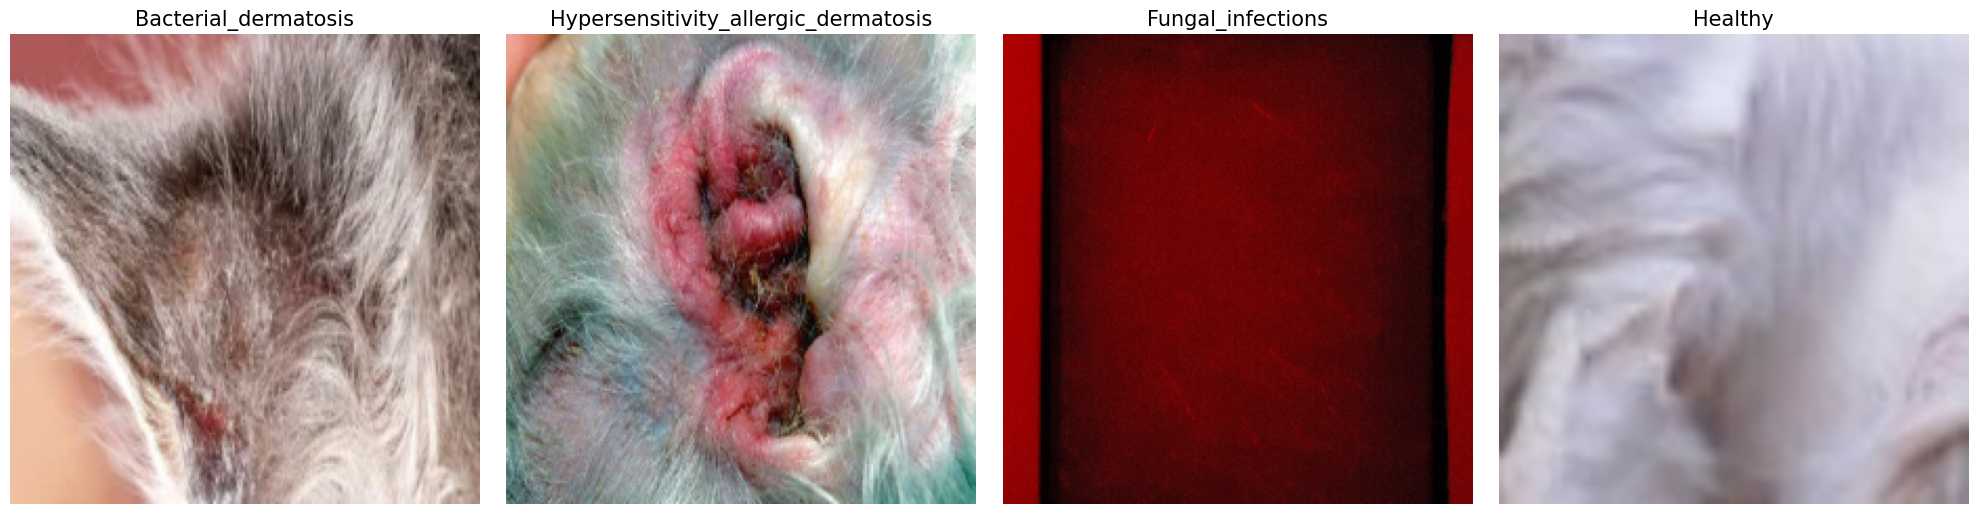

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

dataset_path = "/content/dataset/Dogs"

def load_balanced_sample_images(folder_path, img_size=(224, 224), num_samples=5):
    class_names = os.listdir(folder_path)
    random.shuffle(class_names)  # สลับลำดับคลาสแบบสุ่ม

    images = []
    labels = []

    selected_classes = random.sample(class_names, min(num_samples, len(class_names)))  # สุ่มเลือก class

    for class_name in selected_classes:
        class_path = os.path.join(folder_path, class_name)
        image_files = os.listdir(class_path)
        random.shuffle(image_files)  # สลับลำดับไฟล์ภาพภายในคลาส

        selected_images = random.sample(image_files, min(1, len(image_files)))  # ดึงภาพละ 1 รูปจากแต่ละคลาส

        for img_file in selected_images:
            img_path = os.path.join(class_path, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, img_size)
                images.append(image)
                labels.append(class_name)

    return images, labels

# โหลดภาพใหม่
sample_images, sample_labels = load_balanced_sample_images(dataset_path)

# แสดงภาพใหม่
fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i])
    ax.set_title(sample_labels[i], fontsize=15)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [7]:
pip install split-folders

In [8]:
import splitfolders

# Path ของ dataset เดิม
input_folder = "dataset/Dogs"

# Path ของ dataset ที่แบ่งแล้ว
output_folder = "dataset_split"

# แบ่งเป็น 70% Train, 20% Validation, 10% Test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .2, .1))

Copying files: 443 files [00:00, 1495.10 files/s]


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ของชุดข้อมูลที่แบ่งแล้ว
train_path = "dataset_split/train"
val_path = "dataset_split/val"
test_path = "dataset_split/test"

# Data Augmentation สำหรับ Train Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True
)

# โหลด Train Set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# โหลด Validation Set
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# โหลด Test Set
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # ห้าม shuffle test set
)

Found 303 images belonging to 4 classes.
Found 87 images belonging to 4 classes.
Found 49 images belonging to 4 classes.


In [23]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# ✅ โหลด EfficientNetB3 พร้อม Weights ที่ Pre-trained จาก ImageNet
base_model = EfficientNetB3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-Tune ได้

# ✅ ปลดล็อกแค่ Layer 30+ เพื่อให้ Fine-Tune ได้แต่ไม่ Overfit
for layer in base_model.layers[:30]:
    layer.trainable = False

# ✅ นับจำนวนคลาสใน Dataset
num_classes = len(train_generator.class_indices)

# ✅ สร้างโมเดล CNN-based ใหม่
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation="softmax")
])

# ✅ คอมไพล์โมเดล
model.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ✅ Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()

# ✅ โหลดข้อมูลใหม่ด้วย Augmentation
train_generator = train_datagen.flow_from_directory("/content/dataset_split/train", target_size=(224, 224), batch_size=32, class_mode="categorical")
val_generator = val_datagen.flow_from_directory("/content/dataset_split/val", target_size=(224, 224), batch_size=32, class_mode="categorical")

# ✅ ตั้งค่า Early Stopping และ Save Best Model
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# ✅ ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint]
)

# ✅ โหลดโมเดลที่ดีที่สุด
model = tf.keras.models.load_model("best_model.h5")

Found 303 images belonging to 4 classes.
Found 87 images belonging to 4 classes.
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3004 - loss: 2.7224
Epoch 1: val_loss improved from inf to 1.92140, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 175s 8s/step - accuracy: 0.2992 - loss: 2.7254 - val_accuracy: 0.3218 - val_loss: 1.9214
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.4080 - loss: 2.3104
Epoch 2: val_loss improved from 1.92140 to 1.87897, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 946ms/step - accuracy: 0.4072 - loss: 2.3091 - val_accuracy: 0.3333 - val_loss: 1.8790
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.4461 - loss: 2.1200
Epoch 3: val_loss improved from 1.87897 to 1.84558, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 952ms/step - accuracy: 0.4466 - loss: 2.1205 - val_accuracy: 0.3333 - val_loss: 1.8456
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.5537 - loss: 1.7579
Epoch 4: val_loss improved from 1.84558 to 1.81487, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 863ms/step - accuracy: 0.5528 - loss: 1.7616 - val_accuracy: 0.3793 - val_loss: 1.8149
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.5869 - loss: 1.7626
Epoch 5: val_loss improved from 1.81487 to 1.78930, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 960ms/step - accuracy: 0.5852 - loss: 1.7629 - val_accuracy: 0.3793 - val_loss: 1.7893
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.6115 - loss: 1.7141
Epoch 6: val_loss improved from 1.78930 to 1.76528, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 989ms/step - accuracy: 0.6114 - loss: 1.7084 - val_accuracy: 0.4483 - val_loss: 1.7653
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.6088 - loss: 1.6501
Epoch 7: val_loss improved from 1.76528 to 1.73857, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 937ms/step - accuracy: 0.6080 - loss: 1.6548 - val_accuracy: 0.4253 - val_loss: 1.7386
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.6577 - loss: 1.5410
Epoch 8: val_loss improved from 1.73857 to 1.71119, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 862ms/step - accuracy: 0.6579 - loss: 1.5358 - val_accuracy: 0.4483 - val_loss: 1.7112
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.6892 - loss: 1.4426
Epoch 9: val_loss improved from 1.71119 to 1.69187, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 928ms/step - accuracy: 0.6884 - loss: 1.4404 - val_accuracy: 0.4598 - val_loss: 1.6919
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.6820 - loss: 1.3880
Epoch 10: val_loss improved from 1.69187 to 1.64310, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 949ms/step - accuracy: 0.6833 - loss: 1.3857 - val_accuracy: 0.4943 - val_loss: 1.6431
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.7475 - loss: 1.2835
Epoch 11: val_loss improved from 1.64310 to 1.61845, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 944ms/step - accuracy: 0.7464 - loss: 1.2865 - val_accuracy: 0.4828 - val_loss: 1.6184
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.7113 - loss: 1.3678
Epoch 12: val_loss improved from 1.61845 to 1.58435, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7078 - loss: 1.3703 - val_accuracy: 0.5287 - val_loss: 1.5844
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.7595 - loss: 1.1861
Epoch 13: val_loss did not improve from 1.58435
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 847ms/step - accuracy: 0.7601 - loss: 1.1856 - val_accuracy: 0.5057 - val_loss: 1.5907
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7455 - loss: 1.1225
Epoch 14: val_loss improved from 1.58435 to 1.55216, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7477 - loss: 1.1201 - val_accuracy: 0.5862 - val_loss: 1.5522
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8419 - loss: 1.0415
Epoch 15: val_loss improved from 1.55216 to 1.47585, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8413 - loss: 1.0417 - val_accuracy: 0.6437 - val_loss: 1.4758
Epoch 16/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.8020 - loss: 1.0850
Epoch 16: val_loss improved from 1.47585 to 1.42843, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8044 - loss: 1.0815 - val_accuracy: 0.6667 - val_loss: 1.4284
Epoch 17/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.8016 - loss: 0.9747
Epoch 17: val_loss improved from 1.42843 to 1.40807, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8022 - loss: 0.9783 - val_accuracy: 0.6207 - val_loss: 1.4081
Epoch 18/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.8634 - loss: 0.8772
Epoch 18: val_loss improved from 1.40807 to 1.38092, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8644 - loss: 0.8793 - val_accuracy: 0.6207 - val_loss: 1.3809
Epoch 19/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.8540 - loss: 0.9594
Epoch 19: val_loss improved from 1.38092 to 1.37149, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8526 - loss: 0.9588 - val_accuracy: 0.7011 - val_loss: 1.3715
Epoch 20/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.8878 - loss: 0.8369
Epoch 20: val_loss improved from 1.37149 to 1.36956, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8866 - loss: 0.8413 - val_accuracy: 0.6667 - val_loss: 1.3696
Epoch 21/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8831 - loss: 0.8673
Epoch 21: val_loss did not improve from 1.36956
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 800ms/step - accuracy: 0.8821 - loss: 0.8672 - val_accuracy: 0.6667 - val_loss: 1.3822
Epoch 22/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9148 - loss: 0.8217
Epoch 22: val_loss improved from 1.36956 to 1.33291, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9145 - loss: 0.8248 - val_accuracy: 0.6782 - val_loss: 1.3329
Epoch 23/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8958 - loss: 0.8586
Epoch 23: val_loss improved from 1.33291 to 1.32768, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8963 - loss: 0.8576 - val_accuracy: 0.6667 - val_loss: 1.3277
Epoch 24/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.8282 - loss: 0.9515
Epoch 24: val_loss did not improve from 1.32768
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 855ms/step - accuracy: 0.8321 - loss: 0.9422 - val_accuracy: 0.6782 - val_loss: 1.3460
Epoch 25/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9206 - loss: 0.8039
Epoch 25: val_loss did not improve from 1.32768
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 741ms/step - accuracy: 0.9200 - loss: 0.8040 - val_accuracy: 0.6667 - val_loss: 1.3351
Epoch 26/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9198 - loss: 0.7869
Epoch 26: val_loss improved from 1.32768 to 1.29667, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9211 - loss: 0.7867 - val_accuracy: 0.7011 - val_loss: 1.2967
Epoch 27/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9391 - loss: 0.7351
Epoch 27: val_loss did not improve from 1.29667
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 813ms/step - accuracy: 0.9369 - loss: 0.7409 - val_accuracy: 0.7241 - val_loss: 1.3177
Epoch 28/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.8972 - loss: 0.8213
Epoch 28: val_loss did not improve from 1.29667
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 818ms/step - accuracy: 0.8975 - loss: 0.8199 - val_accuracy: 0.7356 - val_loss: 1.3248
Epoch 29/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9577 - loss: 0.6910
Epoch 29: val_loss did not improve from 1.29667
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 737ms/step - accuracy: 0.9574 - loss: 0.6926 - val_accuracy: 0.7356 - val_loss: 1.3381
Epoch 30/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.9084 - loss: 0.8086
Epoch 30: val_loss did not improve from 1

In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import os

# ✅ โหลดโมเดลที่ดีที่สุด
model = tf.keras.models.load_model("best_model.h5")

# ✅ โหลด Test Data Generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    "/content/dataset_split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# ✅ ทดสอบโมเดลกับชุดข้อมูล Test
test_loss, test_acc = model.evaluate(test_generator)
print(f"⭐ Test Accuracy: {test_acc:.4f}")
print(f"⭐ Test Loss: {test_loss:.4f}")


Found 49 images belonging to 4 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.5580 - loss: 1.7425
⭐ Test Accuracy: 0.5714
⭐ Test Loss: 1.7290


In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_disease(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_names = ["Bacterial Dermatosis", "Fungal Infection", "Hypersensitivity Dermatitis", "Healthy"]
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100  # เปลี่ยนเป็น %

    return f"{predicted_class} (Confidence: {confidence:.2f}%)"

# ทดสอบกับภาพจริง
test_img = "/content/dataset_split/test/Hypersensitivity_allergic_dermatosis/pic1.jpg"
result = predict_disease(test_img, model)
print(f"🔹 Prediction: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
🔹 Prediction: Hypersensitivity Dermatitis (Confidence: 80.85%)


In [26]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"🔹 Test Accuracy: {test_acc:.4f}")
print(f"🔹 Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.5580 - loss: 1.7425
🔹 Test Accuracy: 0.5714
🔹 Test Loss: 1.7290


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


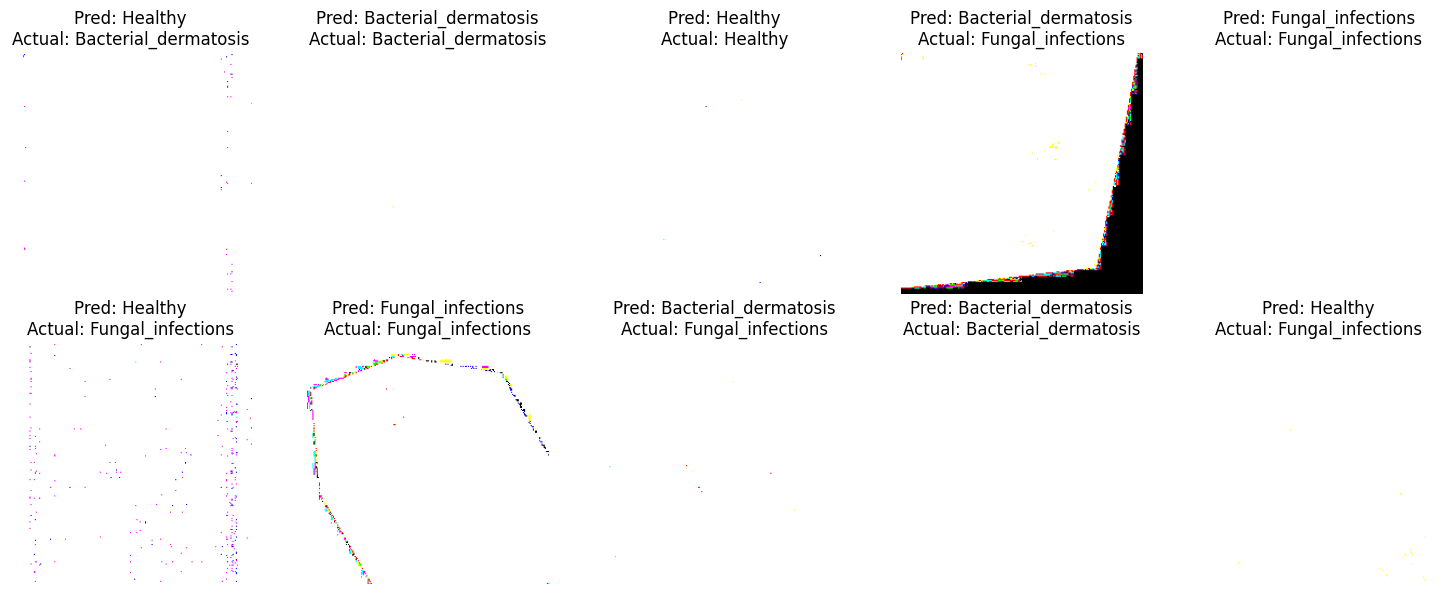

In [27]:
import random
import matplotlib.pyplot as plt

# เลือกรูปแบบสุ่มจาก Test Set
test_images, test_labels = next(test_generator)
random_indices = random.sample(range(len(test_images)), 10)  # สุ่ม 10 รูป

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    img = test_images[idx]

    # ทำนายผล
    prediction = model.predict(np.expand_dims(img, axis=0))
    class_names = list(test_generator.class_indices.keys())
    predicted_label = class_names[np.argmax(prediction)]

    # แสดงภาพ
    ax.imshow(img)
    ax.set_title(f"Pred: {predicted_label}\nActual: {class_names[np.argmax(test_labels[idx])]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


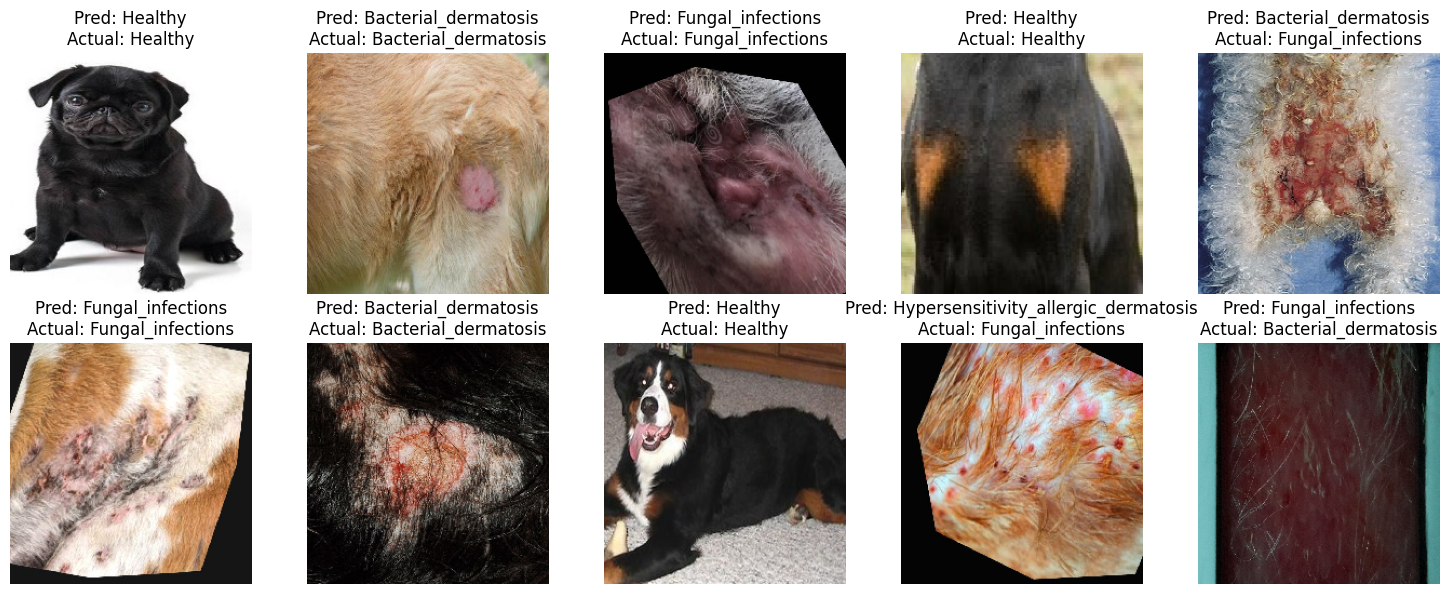

In [33]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ดึงข้อมูลจาก Test Generator
test_images, test_labels = next(test_generator)
random_indices = random.sample(range(len(test_images)), 10)  # สุ่ม 10 รูป

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    img = test_images[idx]

    # 🔹 แปลงค่าให้อยู่ในช่วง [0, 255] และใช้ dtype เป็น uint8
    if img.max() <= 1.0:
        img_display = (img * 255).astype(np.uint8)  # แปลงเป็น uint8
    else:
        img_display = img.astype(np.uint8)

    # 🔹 ทำนายผล
    prediction = model.predict(np.expand_dims(img, axis=0))  # **ไม่ Normalize ซ้ำ**
    class_names = list(test_generator.class_indices.keys())
    predicted_label = class_names[np.argmax(prediction)]
    actual_label = class_names[np.argmax(test_labels[idx])]

    # 🔹 แสดงภาพ
    ax.imshow(img_display)  # ใช้ภาพที่ถูก Normalize กลับมาแล้ว
    ax.set_title(f"Pred: {predicted_label}\nActual: {actual_label}")
    ax.axis("off")

plt.tight_layout()
plt.show()
